In [1]:
# Standard libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.var_model import VAR
import scipy.optimize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_neuro_perf
from matlab.matlab_lib import loadmat
from qt_wrapper import gui_fpath, gui_fname
from autoregression_lib import AR_MLE, AR_PREDICT

Appended library directory /home/alyosha/work/TNU2019-Project/src/lib


## 0. Loading data

In [2]:
# Read LVM file from command line
#filepath_h5 = gui_fname("Select data directory", './', filter='HDF5 files (*.h5)')
data_path = '../../data/intermediate/packageNeuroBehavioural.h5'
h5f = h5py.File(data_path, 'r')
dataAll = np.copy(h5f['megadata'])
h5f.close()

dataNeuro = dataAll[:,:,:12]
dataBehaviour = dataAll[:,:,12:]

nTrials, nTimes, nChannels = dataNeuro.shape
nBehaviourVar = dataBehaviour.shape[2]

print("Loaded neuronal data with (nTrials, nTimes, nChannels) =", dataNeuro.shape, "; behaviour variables", nBehaviourVar)

Loaded neuronal data with (nTrials, nTimes, nChannels) = (590, 161, 12) ; behaviour variables 6


## Naive Multivariate Autoregression Model - neuro + behaviour

The autoregressive process of order $p$ together with external input $u$ is given by

$$X_i(t) = \sum_{jk} A^j_{ik} X_k(t-j) + \sum_{k} B_{ik} U_k(t-1) + \epsilon_i$$

In [3]:
PMAX = 10

dataNeuroTP     = dataNeuro.transpose((2,0,1))
dataBehaviourTP = dataBehaviour.transpose((2,0,1))
print("Unfitted residual ", np.linalg.norm(dataNeuroTP)**2)

LR_lst = []
A_lst_lst = []
B_lst = []
for p in range(1,PMAX+1):
    A_lst, B = AR_MLE(dataNeuroTP, p, dataBehaviourTP)
    dataPred = AR_PREDICT(dataNeuroTP, p, A_lst, dataBehaviourTP, B)
    residual = dataNeuroTP[:,:,p:] - dataPred
    L2 = np.linalg.norm(residual)**2
    var = np.var(dataNeuroTP)
    LR_lst += [L2/var]
    A_lst_lst += [A_lst]
    B_lst += [B]
    
    print("For order",p,"residual is", L2, "log-likelihood-ratio", L2/var)

Unfitted residual  1139880.0000000002
For order 1 residual is 185607.32542487836 log-likelihood-ratio 185607.32542487828
For order 2 residual is 181568.15590718354 log-likelihood-ratio 181568.15590718345
For order 3 residual is 176838.9978177522 log-likelihood-ratio 176838.99781775213
For order 4 residual is 174207.0786601685 log-likelihood-ratio 174207.07866016842
For order 5 residual is 171953.48525050035 log-likelihood-ratio 171953.48525050026
For order 6 residual is 170055.42019430012 log-likelihood-ratio 170055.42019430004
For order 7 residual is 168415.16975194737 log-likelihood-ratio 168415.16975194728
For order 8 residual is 166886.46057258677 log-likelihood-ratio 166886.4605725867
For order 9 residual is 165427.23101166225 log-likelihood-ratio 165427.23101166217
For order 10 residual is 164018.50618565406 log-likelihood-ratio 164018.50618565397


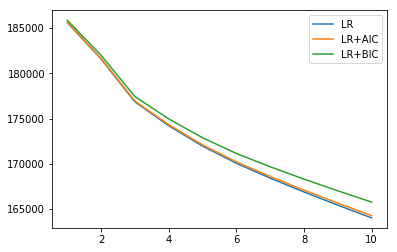

In [4]:
################################
#  Compute Fitness Criteria
################################

parr = np.linspace(1, PMAX, PMAX)
AIC = 2 * nChannels * parr + 2 * nBehaviourVar
N_DATAPOINTS = nTrials  * nChannels * (nTimes - parr)
BIC = AIC / 2 * np.log(N_DATAPOINTS)

LR_arr = np.array(LR_lst)

plt.figure()
plt.plot(parr, LR_arr, label="LR")
plt.plot(parr, LR_arr+AIC, label="LR+AIC")
plt.plot(parr, LR_arr+BIC, label="LR+BIC")
plt.legend()
plt.show()

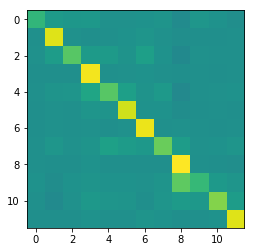

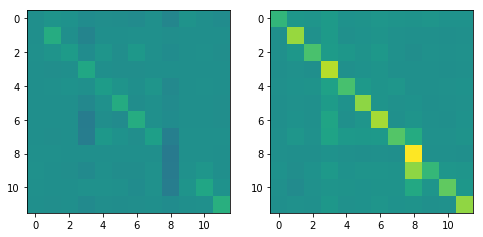

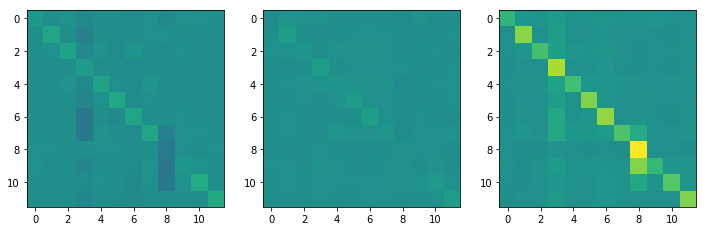

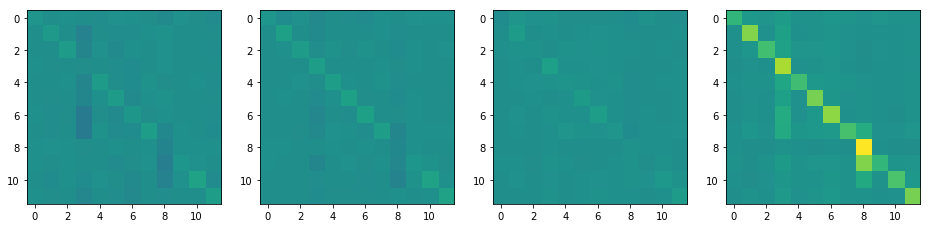

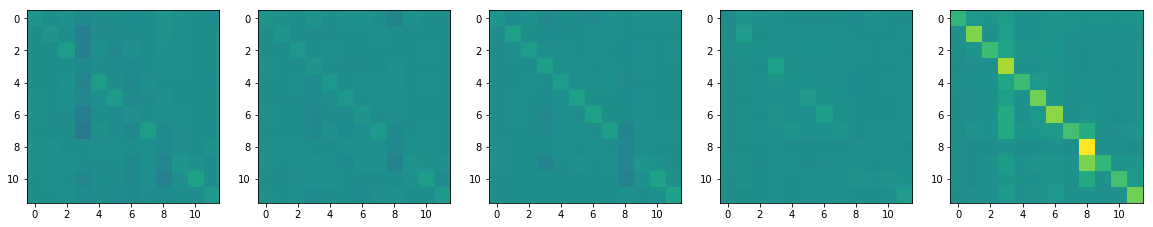

In [5]:
for p in range(5):
    A_lst = A_lst_lst[p]
    N_PLOT = len(A_lst)
    fig, ax = plt.subplots(ncols=N_PLOT, figsize=(4*N_PLOT, 4), squeeze=False)
    for i in range(N_PLOT):
        ax[0, i].imshow(A_lst[i], vmin = -1, vmax=1)
plt.show()

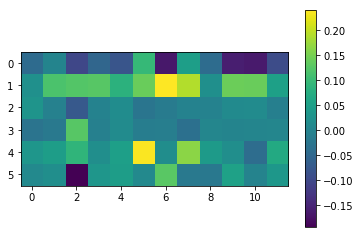

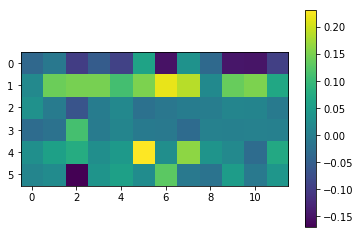

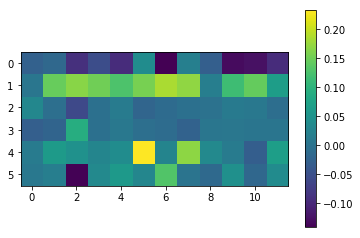

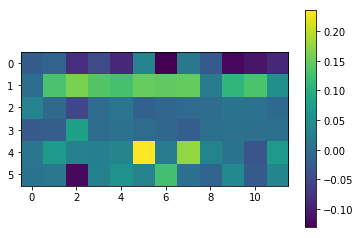

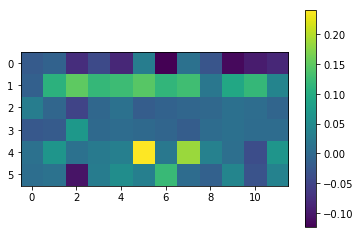

In [6]:
for p in range(5):
    plt.figure()
    plt.imshow(B_lst[p].T)
    plt.colorbar()
plt.show()

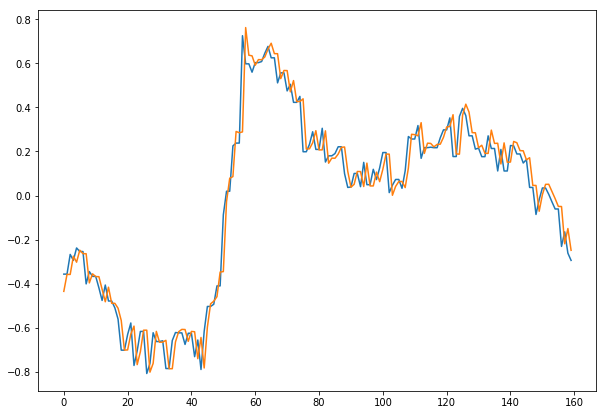

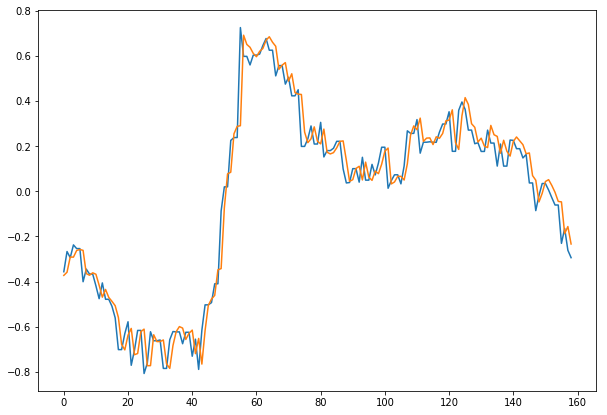

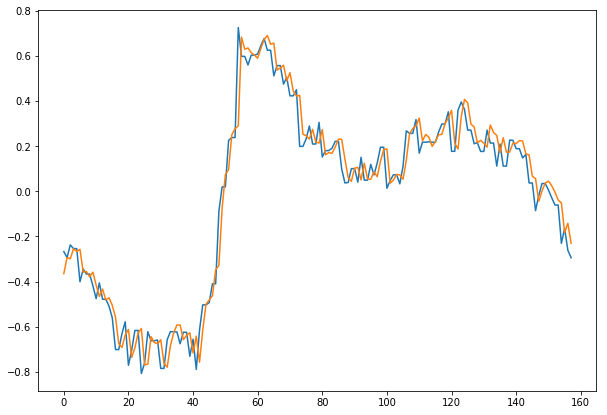

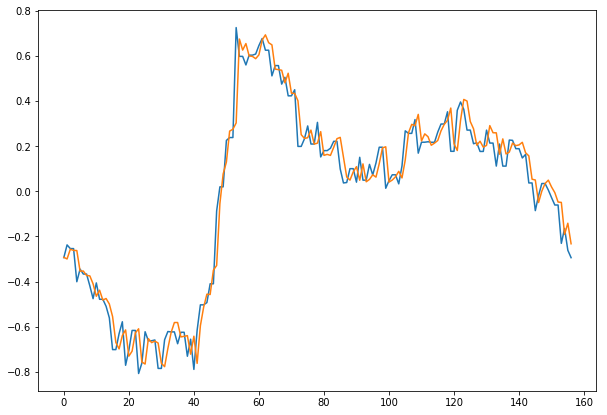

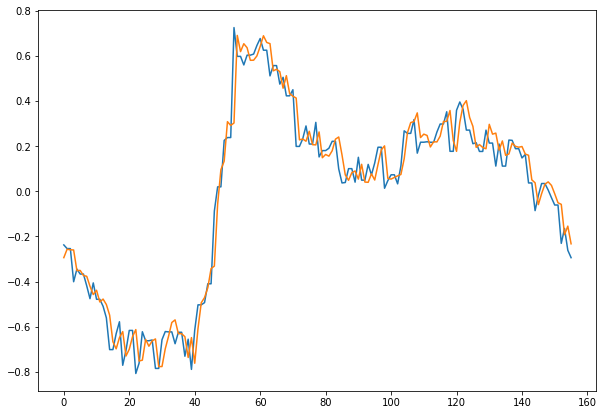

In [7]:
EXAMPLE_TRIAL = 10
EXAMPLE_CHANNEL = 3

for p in range(5):
    A_lst = A_lst_lst[p]
    dataPred = AR_PREDICT(dataNeuroTP, p+1, A_lst, dataBehaviourTP, B)

    plt.figure(figsize = (10, 7))
    plt.plot(dataNeuroTP[EXAMPLE_CHANNEL, EXAMPLE_TRIAL, p+1:])
    plt.plot(dataPred[EXAMPLE_CHANNEL, EXAMPLE_TRIAL, :])
    plt.show()
    
plt.show()

## Trial-Separation

Ok, now we try to estimate AR(1) model individually for each trial

In [8]:
#data_path = gui_fpath("Select data path", './')
data_path = '../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour'

# Read LVM file from command line
dataNeuroRaw, behaviour = read_neuro_perf(data_path)

Reading Yaro data from ../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour


Unfitted residual  1139880.0000000002
iGO 280


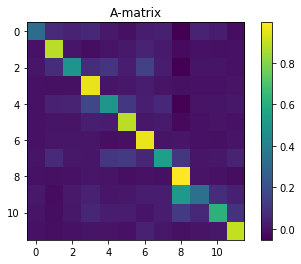

iNOGO 238


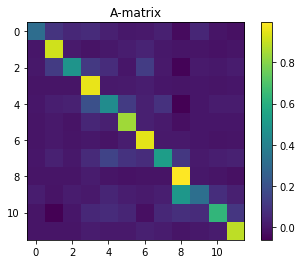

iMISS 16


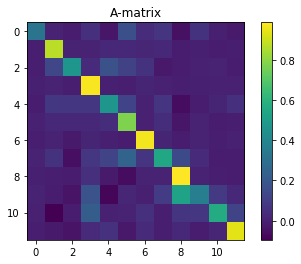

iFA 56


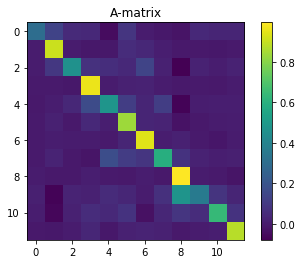

In [12]:
print("Unfitted residual ", np.linalg.norm(dataNeuroTP)**2)

for behType in ['iGO', 'iNOGO', 'iMISS', 'iFA']:
    print(behType, len(behaviour[behType]))
    
    idxTrial = behaviour[behType] - 1
#     A_lst, B = AR_MLE(dataNeuroTP[:, idxTrial, :], 1, dataBehaviourTP[:, idxTrial, :])
    A_lst = AR_MLE(dataNeuroTP[:, idxTrial, :], 1)
    
    plt.figure()
    plt.title('A-matrix')
    plt.imshow(A_lst[0])
    plt.colorbar()
    plt.show()
    
#     plt.figure()
#     plt.title('B-matrix')
#     plt.imshow(B)
#     plt.colorbar()
#     plt.show()